In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import os
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.transform import resize
import mediapipe as mp
from FaceLandmark import *
from image_warp import *
import scipy 

In [2]:
def mesh_latest():
        left_eye = [
            226,
            247,
            247,
            30,
            30,
            29,
            29,
            27,
            27,
            28,
            28,
            56,
            56,
            190,
            190,
            244,
            244,
            112,
            112,
            26,
            26,
            22,
            22,
            23,
            23,
            24,
            24,
            110,
            110,
            25,
            25,
            226,
        ]
        right_eye = [
            463,
            414,
            414,
            286,
            286,
            258,
            258,
            257,
            257,
            259,
            259,
            260,
            260,
            467,
            467,
            446,
            446,
            255,
            255,
            339,
            339,
            254,
            254,
            253,
            253,
            252,
            252,
            256,
            256,
            341,
        ]
        full_mesh_connection = mp.solutions.face_mesh.FACEMESH_TESSELATION

        r_eye_mesh_connection = mp.solutions.face_mesh.FACEMESH_LEFT_EYE
        l_eye_mesh_connection = mp.solutions.face_mesh.FACEMESH_RIGHT_EYE

        result = full_mesh_connection - r_eye_mesh_connection - l_eye_mesh_connection
        list_landmarks = []
        for i in result:
            list_landmarks.append(i[0])
            list_landmarks.append(i[1])
        only_landmark_1 = list(set(list_landmarks))
        only_landmark = []
        eyes_ = list(set(right_eye))
        eyes_r = list(set(left_eye))
        for i in only_landmark_1:
            if i in eyes_ or i in eyes_r:
                pass
            else:
                only_landmark.append(i)

        return only_landmark


In [3]:
def get_coordinates(processed_image):
        landmark = mesh_latest()
        x_lan = []
        y_lan = []
        for lan in landmark:
            x_lan.append(processed_image.multi_face_landmarks[0].landmark[lan].x)
            y_lan.append(processed_image.multi_face_landmarks[0].landmark[lan].y)

        x_values = np.array(x_lan)
        y_values = np.array(y_lan)
        return x_values, y_values

In [4]:
def normal_image(target_img_path):
        img = cv2.imread(target_img_path)
        dstIm = Image.fromarray(img)


        # dstIm = dstIm.resize((1080, 720))
        landmark = FaceLandmark()
        proccessed_1 = landmark.process(cv2.imread(target_img_path))
        dst_pts = []
        x_values, y_values = get_coordinates(proccessed_1)
        for x, y in zip(x_values, y_values):
            dst_pts.append((img.shape[1] * x, img.shape[0] * y))

        return dstIm, dst_pts

In [5]:
def normalize_shape(
        input_image,
        processed_image,
        target_img_path,
        dstIm,dst_pts,
        show=False,
        get_location=False,
    ):
        # Load source image
        srcIm = Image.fromarray(input_image)
        
        # dstIm = resize(dstIm, (1620, 1080), anti_aliasing=True)
        src_pts = []
        x_values, y_values = get_coordinates(processed_image)
        for x, y in zip(x_values, y_values):
            src_pts.append((input_image.shape[1] * x, input_image.shape[0] * y))

        # ------------------------------------- Affine transformation хийх  ---------------######
        mean_array = np.array(dstIm.convert("L"))
        ymin, ymax, xmin, xmax, img_mask = PiecewiseAffineTransform(
            srcIm, src_pts, dstIm, dst_pts
        )

        shape_normalized_img = np.array(dstIm)

        mean_array = mean_array

        try:
            shape_normalized_img = (shape_normalized_img*(img_mask!=0))[xmin:xmax, ymin:ymax]   
        except:
            shape_normalized_img = (shape_normalized_img[xmin:xmax, ymin:ymax]*(img_mask!=0))
        # ------------------------------------- END  -----------------------------######
        return shape_normalized_img

In [6]:
def create_normal_image(save_texture_data_dir,data_dir,target_img_path):
    shape_normalized_texture_data, shape_normalized_texture_data_full_res = [], []
    landmark = FaceLandmark()
    dstIm, dst_pts = normal_image(target_img_path)
    for i, img_path in enumerate(sorted(os.listdir(data_dir))):
        if not '.jpg' in img_path:
            continue

        individual_img_path = os.path.join(data_dir, img_path)

        
        image = cv2.cvtColor(cv2.imread(individual_img_path),cv2.COLOR_BGR2RGB) 
        # print(image.shape)
        processed_image = landmark.process(image)
        shape_normalized_texture = normalize_shape(
            image,
            processed_image,
            target_img_path, dstIm, dst_pts
        )

        imsave(os.path.join(save_texture_data_dir, img_path), shape_normalized_texture)
        shape_normalized_texture_data.append(
            np.expand_dims(rgb2gray(shape_normalized_texture), 0)
        )
        shape_normalized_texture_data_full_res.append(
            np.expand_dims(shape_normalized_texture, 0)
        )
       
    shape_normalized_texture_data = np.concatenate(
            shape_normalized_texture_data, axis=0
        )
    shape_normalized_texture_data_full_res = np.concatenate(
            shape_normalized_texture_data_full_res, axis=0
        )
        

    return (
            shape_normalized_texture_data,
            shape_normalized_texture_data_full_res)

In [10]:
lists = ["l1","l2","l3","l4","l5","l6","l7","r1","r2","r3","r4","r5","r6","r7","n"]

for i in lists:
    save_texture_data_dir = "..//..//data/test1/{}/shape_normalized_images".format(i)
    data_dir = "..//..//data/test1/{}/".format(i)
    target_img_path = "..//..//data/test1/{}/frame_n.jpg".format(i)
    shape_normalized_texture_data, shape_normalized_texture_data_full_res = create_normal_image(save_texture_data_dir,data_dir,target_img_path)
    print(i)

l7
r7


In [11]:
def compute_mean(images):
    height, width, channels = images[0].shape

    mean_image = np.zeros((height, width, channels), dtype=np.float64)
    for image in images:
        mean_image += image
    num_images = len(images)
    mean_image /= num_images

    mean_image = mean_image.astype(np.uint8)

    beta = np.mean(images, keepdims=True)
    alpha = np.mean(images*mean_image, keepdims=True)
    normalized_data = (images-beta)/alpha

    return [mean_image],normalized_data

In [12]:
def create_mean_image(data_dir,save_data_dir):
    shape_normalized_texture_data, shape_normalized_texture_data_full_res = [], []

    for i, img_path in enumerate(sorted(os.listdir(data_dir))):
        if not '.jpg' in img_path:
            continue
        individual_img_path = os.path.join(data_dir, img_path)
        image = cv2.cvtColor(cv2.imread(individual_img_path),cv2.COLOR_BGR2RGB) 
        # plt.imshow(image)
        shape_normalized_texture_data_full_res.append(image)
        # shape_normalized_texture_data_full_res.append(
        #     np.expand_dims(image, 0)
        # )
   
    mean,normalized_data = compute_mean(shape_normalized_texture_data_full_res)
    np.save(save_data_dir,mean[0])

In [14]:
lists = ["l1","l2","l3","l4","l5","l6","l7","r1","r2","r3","r4","r5","r6","r7","n"]
for i in lists:
    data_dir_mean =  "..//..//data/test1/{}/shape_normalized_images".format(i)
    save_data_dir =  "../../result/mean_1/mean_{}.npy".format(i)
    create_mean_image(data_dir_mean,save_data_dir)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segm

In [16]:
lists = ["l1","l2","l3","l4","l5","l6","l7","r1","r2","r3","r4","r5","r6","r7","n"]
# lists = ["l7","r7"]

list_mean = []
for i in lists:
    
    save_data_dir =  "../../result/mean_1/mean_{}.npy".format(i)
    list_mean.append( np.array(np.load(save_data_dir)) )

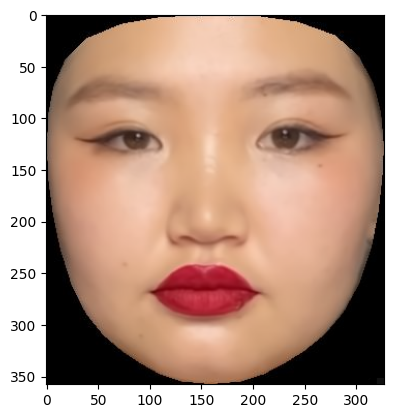

In [31]:
plt.imshow(list_mean[14])

In [28]:
pixels = list_mean[14].reshape(-1, 3)

In [31]:
covariance_matrix = np.cov(pixels, rowvar=False)

In [55]:
eig_values, eig_vecs = np.linalg.eig(covariance_matrix)

In [63]:
covariance_matrix

array([[6172.19126907, 4604.24134123, 3369.05071248],
       [4604.24134123, 3506.82106158, 2596.32365451],
       [3369.05071248, 2596.32365451, 1961.45545429]])

In [56]:
def findt(eig_values, percent):

	total = sum(eig_values)
	total = percent * total
	p = 0
	t = 0 
	for i in range(len(eig_values)):
		p = p + eig_values[i]
		if p >= total:
			t = i
			break
	return t
def get_rrmse(A,B):
	rrmse = np.sqrt(np.sum((A-B)**2)/np.sum(A**2))
	return rrmse


In [57]:
t = findt(eig_values, 0.985)
eig_values = np.real(eig_values[0:t]) 
eig_vecs = np.real(eig_vecs[:, 0:t])


In [ ]:
lists_new = []

In [54]:
for k in list_mean:
    #k = cv2.resize(k,(376, 324))
    print(k.shape)

(376, 324, 3)
(371, 326, 3)
(377, 326, 3)
(379, 318, 3)
(366, 319, 3)
(363, 319, 3)
(338, 295, 3)
(385, 330, 3)
(381, 329, 3)
(373, 326, 3)
(379, 328, 3)
(374, 327, 3)
(378, 322, 3)
(378, 311, 3)
(373, 322, 3)


In [58]:
model_fit_coeff = np.dot(np.linalg.pinv(eig_vecs), list_mean[0] - list_mean[14] )

ValueError: operands could not be broadcast together with shapes (376,324,3) (373,322,3) 